# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 01.12.2022

Мягкий дедлайн: 23:59MSK 11.12.2022

Жесткий дедлайн: 23:59MSK 15.12.2022

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

C:\Users\dm1tr\Desktop\machine-learning-first\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the Cal

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведена следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z ** 2).mean()

34.892269170614405

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).np.random.choice

In [7]:
import warnings


def compute_bias_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """

    np.random.seed(124)

    all_preds = np.empty((y.shape[0], num_runs))
    all_preds[:] = np.nan
    errors = []

    for i in range(num_runs):
        sample_indexes = np.random.choice(X.shape[0], X.shape[0])
        mask = np.zeros(X.shape[0], dtype=bool)
        mask[sample_indexes] = True

        cur_X_train = X[mask]
        cur_y_train = y[mask]
        regressor.fit(cur_X_train, cur_y_train)
        cur_X_test = X[~mask]
        cur_y_test = y[~mask]

        cur_y_pred = regressor.predict(cur_X_test)
        all_preds[~mask, i] = cur_y_pred
        errors.extend((cur_y_test - cur_y_pred) ** 2)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        avg_ans = np.nanmean(all_preds, axis=1)
        avg_var = np.nanvar(all_preds, axis=1)

        bias = np.nanmean((y - avg_ans) ** 2)
        var = np.nanmean(avg_var)

    return bias, var, np.array(errors).mean()

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

np.random.seed(124)
models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]

for model in models:
    bias, var, err = compute_bias_variance(model, X, y, 100)
    print(type(model).__name__, ':= Bias:', bias, '| Variance:', var, '| Error:', err)

LinearRegression := Bias: 23.79945000067844 | Variance: 0.5703206049840485 | Error: 24.111359960252877
DecisionTreeRegressor := Bias: 10.788612569598433 | Variance: 12.180256800159336 | Error: 22.830467858095492
RandomForestRegressor := Bias: 11.0483166371494 | Variance: 1.411567615627922 | Error: 12.286120852236074


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__
* Как мы видим, простая модель линейной регрессии обладает высоким смещением (плохо подгоняется под данные) и маленьким разбросом (опять же, из-за ее простоты)
* Решающее дерево имеет очень высокий разброс, по сравнению с остальными моделями, и наименьшее смещение, так как оно очень сильно переобучается и отлично подгоняется под выборку
* Случайный лес имеет в разы меньший разброс, в сравнении с деревом, но больше чем у самой простой линейной регрессии, смещение при этом чуть выше чем у дерева

Результат полностью ожидаем и согласуется

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__ В теории, если базовые алгоритмы независимы, то разброс алгоритма уменьшается в N (кол-во базовых алгоритмов) раз. Но у нас видно уменьшение явно не в 10 раз
Все потому, что базовые алгоритмы зависимые и в итоговой формуле смещения для бэггинга появляется слагаемое в виде ковариации базовых алгоритмов

In [9]:
from sklearn.ensemble import BaggingRegressor

np.random.seed(124)
for model in models:
    bagging = BaggingRegressor(model)
    # 10 Моделей в бэггинге
    bias, var, err = compute_bias_variance(bagging, X, y, 100)
    print(type(model).__name__, ':= Bias:', bias, '| Variance:', var, '| Error:', err)

LinearRegression := Bias: 23.682546892635585 | Variance: 0.6828325659197105 | Error: 24.14625242318349
DecisionTreeRegressor := Bias: 11.041666197384362 | Variance: 2.689797018242699 | Error: 13.52895881786574
RandomForestRegressor := Bias: 12.46577945377973 | Variance: 0.8163485386548294 | Error: 13.109886290964962


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [10]:
def plot_predictions(regressor, X, y, axes, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    np.random.seed(124)

    test_sample_indexes = np.random.choice(X.shape[0], num_test_objects, replace=False)
    test_mask = np.zeros(X.shape[0], dtype=bool)
    test_mask[test_sample_indexes] = True

    X_test = X[test_mask]
    y_test = y[test_mask]
    X_train = X[~test_mask]
    y_train = y[~test_mask]

    y_preds = []

    for i in range(num_runs):
        sample_indexes = np.random.choice(X_train.shape[0], X_train.shape[0])
        mask = np.zeros(X_train.shape[0], dtype=bool)
        mask[sample_indexes] = True

        cur_X_train = X_train[mask]
        cur_y_train = y_train[mask]
        regressor.fit(cur_X_train, cur_y_train)

        cur_y_pred = regressor.predict(X_test)
        y_preds.append(cur_y_pred)

    x_plot = []
    y_plot = []
    for i in range(num_test_objects):
        for y_pred in y_preds:
            y_plot.append(y_pred[i])
            x_plot.append(i)

    axes.scatter(x_plot, y_plot, label='prediction', c='r')
    # Черный не видно в темной теме ide
    axes.scatter(range(num_test_objects), y_test, c='c', label='real answer')
    axes.set_xlabel('object')
    axes.set_ylabel('target')
    axes.legend()
    axes.set_title(title)

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

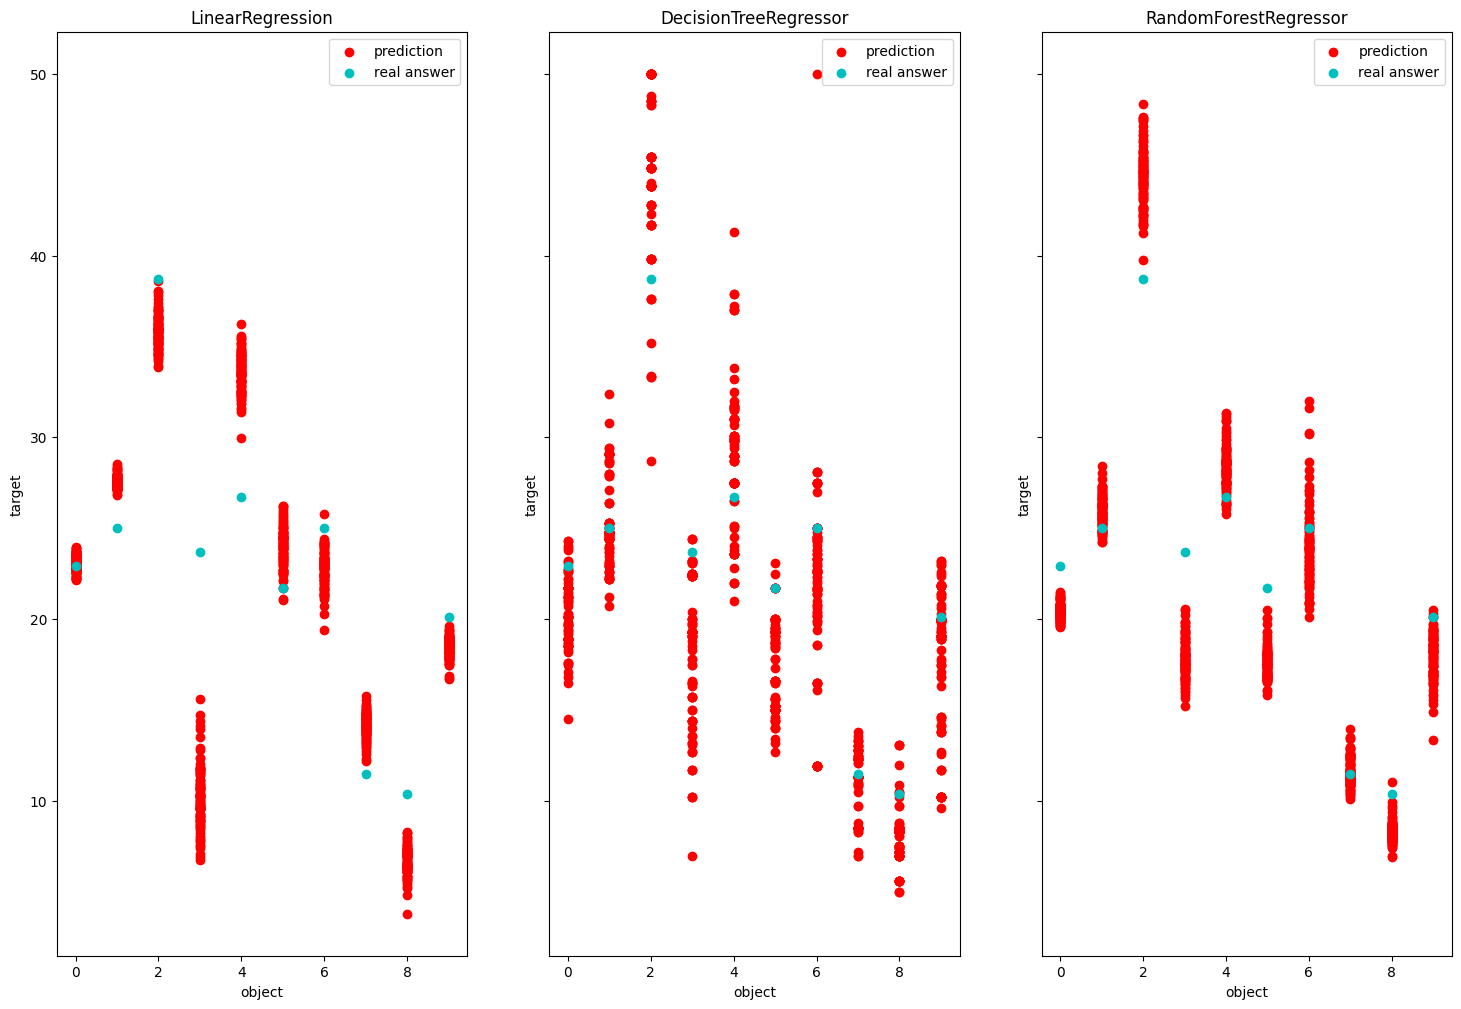

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 12), sharey='all')
np.random.seed(124)

for model, ax in zip(models, axes):
    plot_predictions(model, X, y, ax, title=type(model).__name__)


plt.show()

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__
* Линейная регрессия: точки предсказаний расположены очень близко друг к другу (низкий разброс), но зачастую далеко от настоящего таргета (высокое смещение)
* Решающее дерево: точки предсказаний сильно разбросаны и с большим размахом (высокий разброс), но зато в каждом столбике истинный таргет заключен внутри полоски предсказаний (низкое смещение)
* Случайный лес: точки предсказаний расположены очень плотно, с размахом чуть больше чем у линейный регрессии (весьма низкий разброс), но таргет как и у линейной регрессии не всегда внутри полоски предсказаний, зато в отличие от линейной регрессии, расстояние между полоской предсказаний и истинным таргетом часто меньше у случайного леса (среднее, скорее даже низкое смещение)


### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [12]:
parameters = {
    'max_depth': np.arange(1, 11, 1, dtype=int),
    'max_features': np.arange(1, X.shape[1] + 1, 1, dtype=int)
}

np.random.seed(123)

biases = []
variances = []

for depth in parameters['max_depth']:
    model = DecisionTreeRegressor(max_depth=depth)
    bias, var, err = compute_bias_variance(model, X, y)

    biases.append(bias)
    variances.append(var)

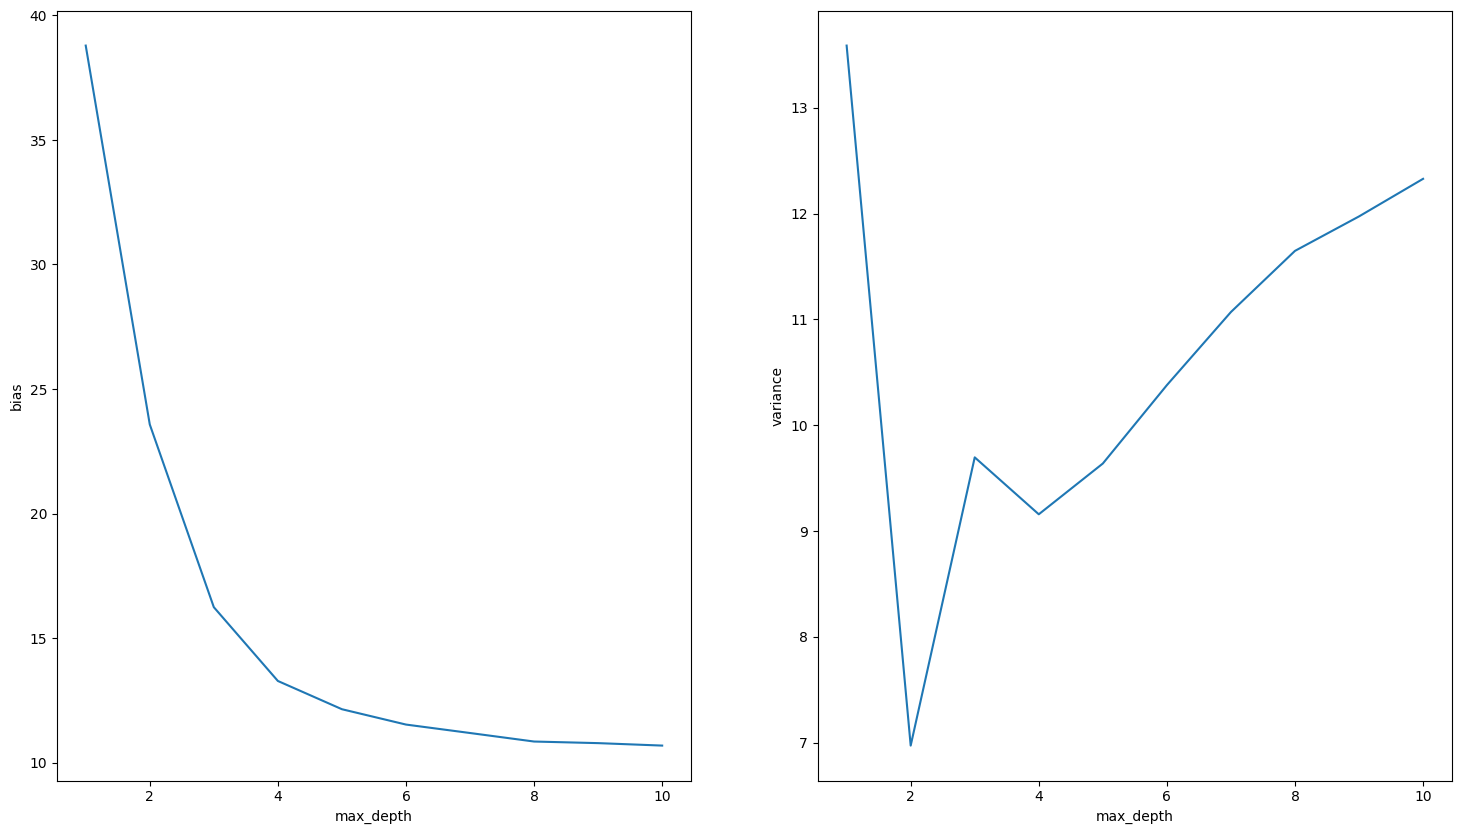

In [13]:
_, axes = plt.subplots(1, 2, figsize=(18, 10))

axes[0].plot(parameters['max_depth'], biases)
axes[0].set_xlabel('max_depth')
axes[0].set_ylabel('bias')

axes[1].plot(parameters['max_depth'], variances)
axes[1].set_xlabel('max_depth')
axes[1].set_ylabel('variance')

plt.show()

In [14]:
np.random.seed(123)

biases = []
variances = []

for max_features in parameters['max_features']:
    model = DecisionTreeRegressor(max_features=max_features)
    bias, var, err = compute_bias_variance(model, X, y)

    biases.append(bias)
    variances.append(var)

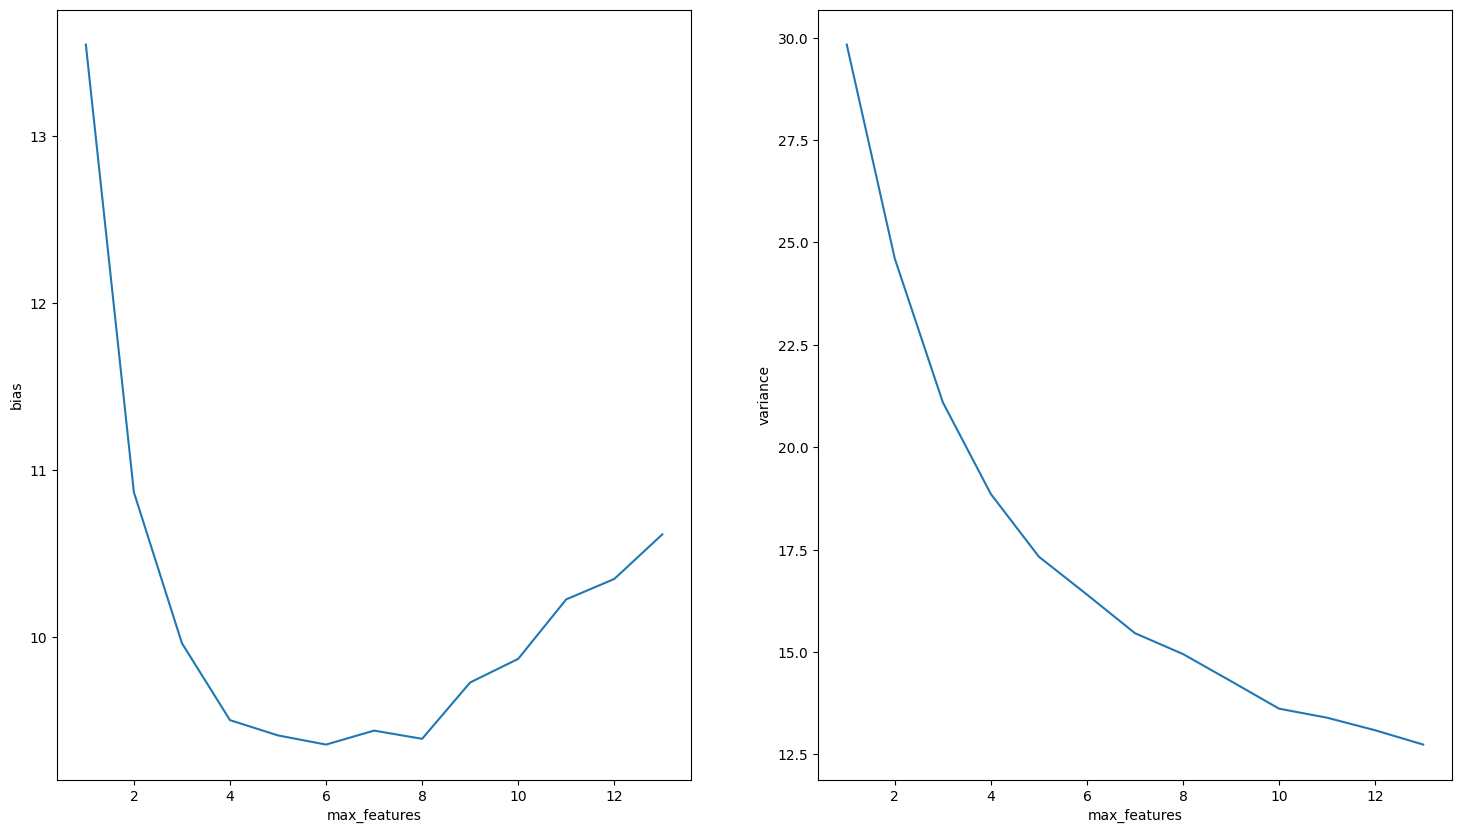

In [15]:
_, axes = plt.subplots(1, 2, figsize=(18, 10))

axes[0].plot(parameters['max_features'], biases)
axes[0].set_xlabel('max_features')
axes[0].set_ylabel('bias')

axes[1].plot(parameters['max_features'], variances)
axes[1].set_xlabel('max_features')
axes[1].set_ylabel('variance')

plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [16]:
parameters = {
    'n_estimators': 2 * np.arange(1, 10, dtype=int)
}

np.random.seed(123)

biases = []
variances = []

for n_estimators in parameters['n_estimators']:
    model = RandomForestRegressor(n_estimators=n_estimators)
    bias, var, err = compute_bias_variance(model, X, y)

    biases.append(bias)
    variances.append(var)

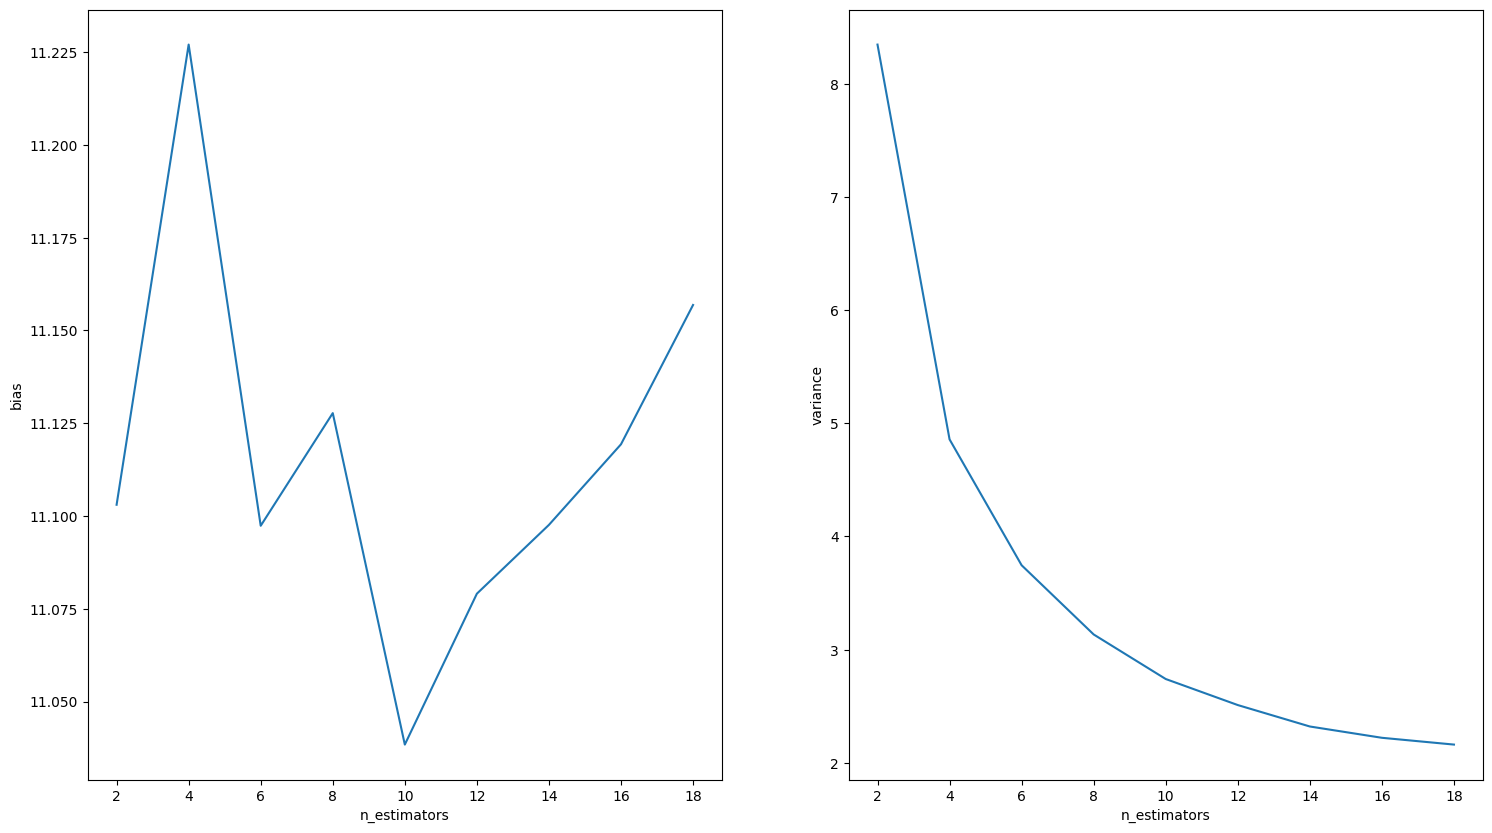

In [17]:
_, axes = plt.subplots(1, 2, figsize=(18, 10))

axes[0].plot(parameters['n_estimators'], biases)
axes[0].set_xlabel('n_estimators')
axes[0].set_ylabel('bias')

axes[1].plot(parameters['n_estimators'], variances)
axes[1].set_xlabel('n_estimators')
axes[1].set_ylabel('variance')

plt.show()

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

np.random.seed(123)

biases = []
variances = []

for n_estimators in parameters['n_estimators']:
    model = GradientBoostingRegressor(n_estimators=n_estimators)
    bias, var, err = compute_bias_variance(model, X, y)

    biases.append(bias)
    variances.append(var)

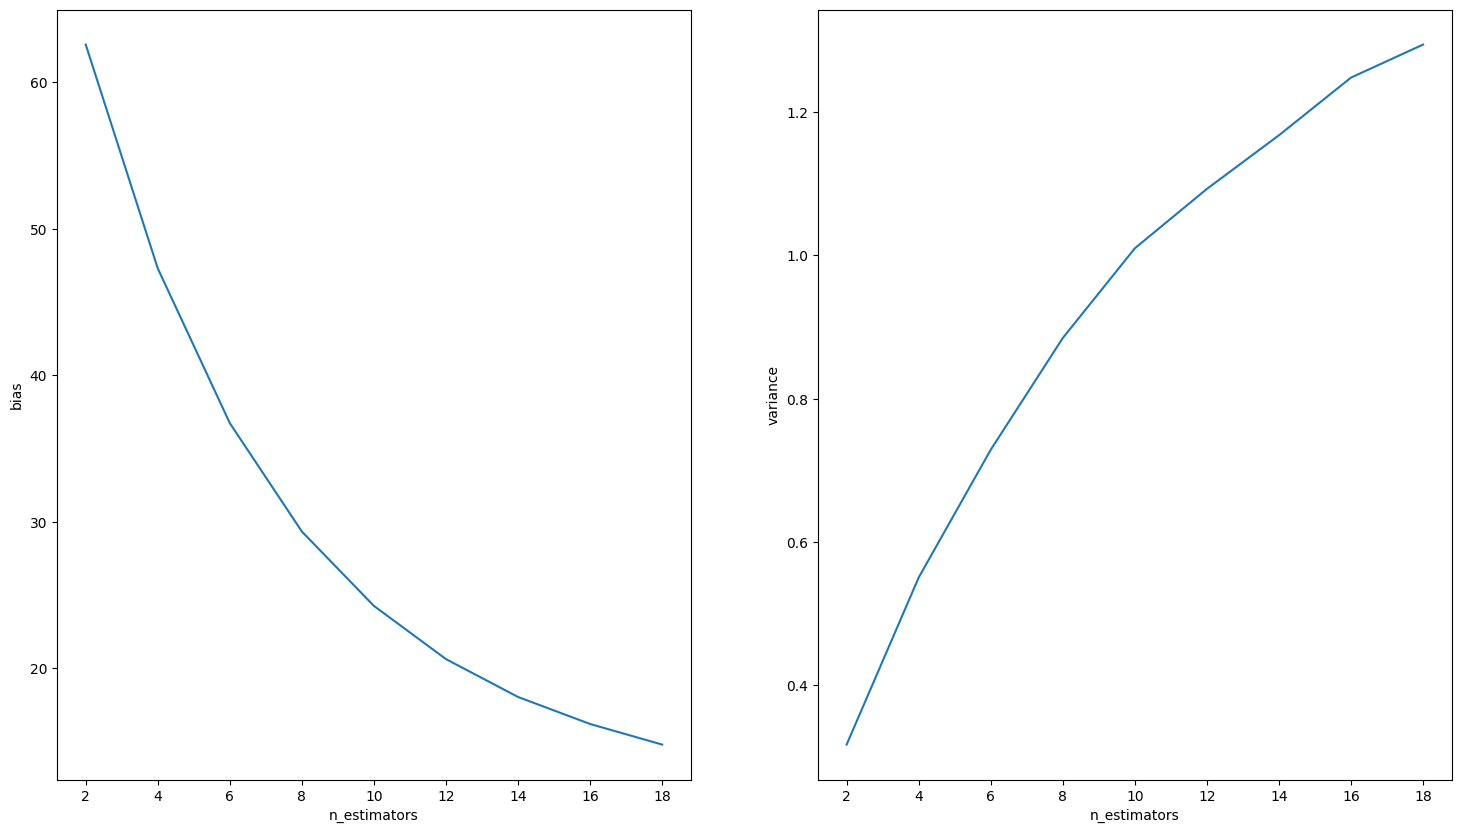

In [19]:
_, axes = plt.subplots(1, 2, figsize=(18, 10))

axes[0].plot(parameters['n_estimators'], biases)
axes[0].set_xlabel('n_estimators')
axes[0].set_ylabel('bias')

axes[1].plot(parameters['n_estimators'], variances)
axes[1].set_xlabel('n_estimators')
axes[1].set_ylabel('variance')

plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

* Решающее дерево, max_depth: с ростом глубины падает смещение, так как дерево становится сложнее и подгоняется под данные.
При этом разброс на решающем пне очень большой, так как там всего один предикат и следовательно предсказания - два средних значения для разбитых всего единожды и одним пердикатом объектов, которые могут существенно отличаться. Далее на глубине 2 он падает до минимума, так как стало вдвое больше листьев, но потом стремительно растет, так как дерево начинает переобучаться и становится нестабильным (при маленьком изменении обучающей выборки прогноз сильно меняется)
* Решающее дерево, max_features: при увеличении числа используемых признаков, сначала смещение падает, так как мы используем больше признаков для нахождения сплита, тем самым не пропускаем важные, но потом начинает расти. Скорее всего, это вызвано тем, что часть признаков не несет в себе много полезной информации в действительности, но при этом используются в жадном алгоритме. То есть из-за них жадный алгоритм может сделать разбиение, которое на самом деле было не очень, но в силу жадности отменить это мы уже не сможем.
Разброс же стабильно убывает - неудивительно, учитывая, что критерий хаотичности для регрессии как правило дисперсия. Используя больше признаков на каждом шаге жадного алгоритма, мы выбираем наилучшим образом понизит дисперсию в дочерних узлах
* Случайные лес, n_estimators: смещение штормит во все стороны, скорее всего, из-за того, что шаг параметра, как и его значение, очень маленькое (деревьев меньше 20 - очень маленький лес)). Так что тут такое поведение создает случайность при построении леса, нежели именно изменение гиперпараметра. Чтобы увидеть влияение n_estimators для случайного леса, следовало бы перебирать куда до большего числа деревьев и с боьшим шагом.
Но при этом видно, что разброс прекрасным образом уменьшается - лес ассамблирует довольно независимые алгоритмы, и, как мы выяснили раннее, это отлично понижает разброс, даже при их маленьком количестве.
* Градиентный бустинг, n_estimators: тут, в отличие от случайного леса, смещение стабильно падает. Все потому, что вместо усреднения результатов в листе среди всех базовых алгоритмов, тут базовые алгоритмы учатся улучшать результат построенной композиции, поэтому каждый шаг понижает смещение.
Разброс при этом начинает расти, хоть и достаточно медленно, так как бустинг - довольно сложная модель, которая, с ростом числа деревьев, склонна к переобучению, в отличие от того же случайного леса

__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

__Your answer here:__